<a href="https://colab.research.google.com/github/Schimmenti/Creep/blob/master/Creep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
from numba import njit,jit
import math
from sklearn.metrics.pairwise import manhattan_distances
import networkx as nx
import pickle

In [35]:
def bin_group(x,y,x_bins, right=False):
    n_bins = 0
    if(type(x_bins) is int):
        n_bins = x_bins
        binning = np.linspace(np.min(x), np.max(x), n_bins)
    else:
        n_bins = len(x_bins)
        binning = x_bins
    x_classes = np.digitize(x,binning, right=right)
    classes_idx = [ np.argwhere(x_classes==c) for c in range(1,n_bins+1)]
    y_groups = [y[classes_idx[c].flatten()]  for c in range(0,n_bins)]
    return binning, y_groups
def mean_bin_group(x,y,x_bins,right=False):
    x_binned,y_groups = bin_group(x,y,x_bins, right)
    y_binned= np.array([np.mean(y_b) if len(y_b)>0 else 0 for y_b in y_groups ])
    mask = y_binned > 0
    return x_binned[mask], y_binned[mask]

def bin_log(data, bins=50):
    if(type(bins) is int):
        binning = np.logspace(0,np.log10(np.max(data)), bins)
    else:
        binning = bins
    hist, edges = np.histogram(data,bins=binning, density=True)
    mask = hist > 0
    hist = hist[mask]
    edges = ((edges[0:-1]+edges[1:])*0.5)[mask]
    return hist, edges, binning
def center(z):
    # "-1" profiles
    # sum of columns
    mask1 = (z==-1).sum(axis=0)
    # sum of rows
    mask2 = (z==-1).sum(axis=1)
    # column at which we find the actual interface
    max1 = mask1.max()
    boundary1 = np.argwhere(mask1 == max1).flatten()
    lb1 = np.argmax(np.diff(boundary1))
    # row at which we find the actual interface
    max2 = mask2.max()
    boundary2 = np.argwhere(mask2==max2).flatten()
    lb2 = np.argmax(np.diff(boundary2))
    # actual boundary
    minb_1, maxb_1 = boundary1[lb1],boundary1[lb1+1]
    minb_2, maxb_2 = boundary2[lb2],boundary2[lb2+1]
    # center
    xc = (minb_1+maxb_1)/2
    yc = (minb_2+maxb_2)/2
    # radii
    radius_x = (maxb_1-minb_1)/2
    radius_y = (maxb_2-minb_2)/2
    return xc,yc,radius_x,radius_y

## Load data

In [3]:
base_link = 'https://raw.githubusercontent.com/Schimmenti/Creep/master/file_field%1.2f.csv'

In [22]:
field = 0.13 # by changining this parameters we pick up different data (0.13, 0.14, 0.15, 0.16) are the available ones
data = pd.read_csv(base_link % field, header=None).values

In [23]:
xc, yc, r_x, r_y = center(data)

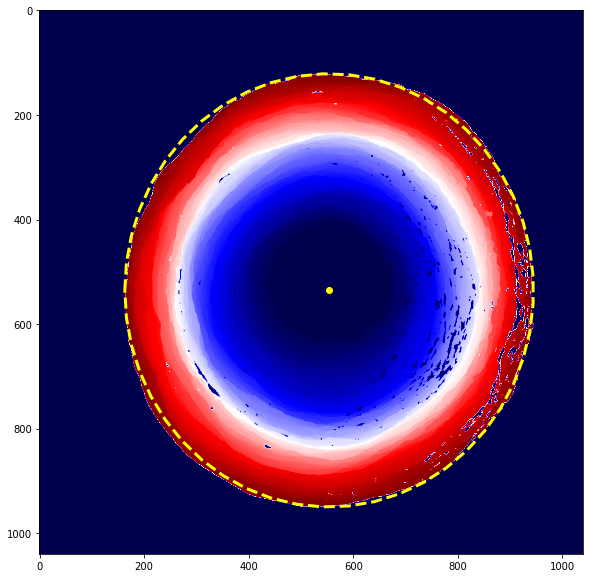

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(data, cmap='seismic')
plt.scatter(xc, yc, c='yellow')
thetas_plot = np.linspace(-np.pi, np.pi )
plt.plot(xc+r_x*np.cos(thetas_plot), yc+r_y*np.sin(thetas_plot), c='yellow', lw=3, ls='dashed')
plt.show()

## Clusters

In [25]:
def build_network(xs,ys,times,time_cut,tol=2):
    network = {}
    for idx, (t,x,y) in enumerate(zip(times,xs,ys)):
        network[t] = []
        for (s,u,v) in zip(times[idx+1:],xs[idx+1:],ys[idx+1:]):
            if((s-t)>time_cut):
                break
            if(np.min(np.abs(x.reshape(-1,1)-u.reshape(1,-1))+np.abs(y.reshape(-1,1)-v.reshape(1,-1))) <=tol):
                network[t].append(s)
    return network

In [26]:
filename='interface%1.2f.pkl' % field
with open(filename, 'rb') as f:
    interface_dict, x_dict, y_dict, t_dict = pickle.load(f)

In [27]:
xs = [x_dict[t] for t in t_dict]
ys = [y_dict[t] for t in t_dict]
ts = list(t_dict.keys())

In [28]:
time_cuts = [16,18,20]
tols = [2]

In [29]:
net_coll = []
for tcut in time_cuts:
    print('t_cut', tcut)
    nets = []
    for tol in tols:
        print('tol', tol)
        net = build_network(xs,ys,ts,tcut,tol)
        nets.append(net)
    net_coll.append(nets)

t_cut 16
tol 2
t_cut 18
tol 2
t_cut 20
tol 2


In [30]:
cl_coll = []
for tcut, nets in zip(time_cuts, net_coll):
    clusters = []
    for tol, net in zip(tols, nets):
        g = nx.Graph()
        g.add_nodes_from(net.keys())
        for k, v in net.items():
            g.add_edges_from(([(k, t) for t in v]))
        sub_graphs = nx.connected_components(g)
        clusters.append([ np.sort(np.array(list(sg))) for sg in sub_graphs])
    cl_coll.append(clusters)

In [32]:
def summary_stat(interface_dict, x_dict,y_dict,clusters):
    jumps = []
    lateral1 = []
    lateral2 = []
    n_angles = []
    for c in clusters:
        temp = 0
        uq_sites = set()
        for idx in c:
            if(idx > 0):
                delta = interface_dict[idx]-interface_dict[idx-1]
                uq_sites.update(list(np.nonzero(delta>0)[0]))
                temp += np.sum(delta)
            else:
                temp += np.sum(interface_dict[0])
                uq_sites.update(list(np.nonzero(interface_dict[0])[0]))
        uq_sites = np.array(list(uq_sites),dtype=int)
        last_h = interface_dict[c[-1]]
        first_h = interface_dict[c[0]]
        lateral1.append(last_h[uq_sites].mean()*len(uq_sites))
        lateral2.append(first_h[uq_sites].mean()*len(uq_sites))
        jumps.append(temp)
        n_angles.append(len(uq_sites))
    return np.array(jumps), np.array(lateral1), np.array(lateral2), np.array(n_angles)

16


<ipython-input-32-a35820ed8cf7>:20: RuntimeWarning: Mean of empty slice.
  lateral1.append(last_h[uq_sites].mean()*len(uq_sites))
<ipython-input-32-a35820ed8cf7>:21: RuntimeWarning: Mean of empty slice.
  lateral2.append(first_h[uq_sites].mean()*len(uq_sites))


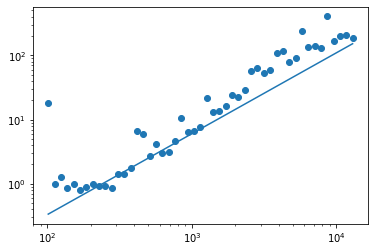

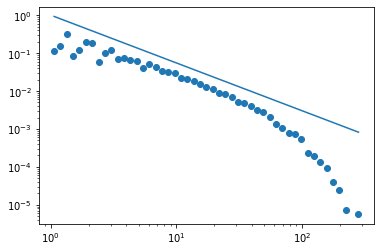

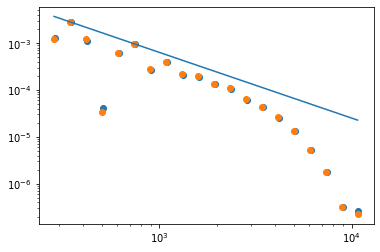

18


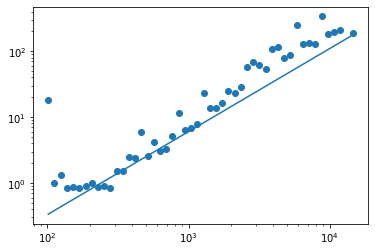

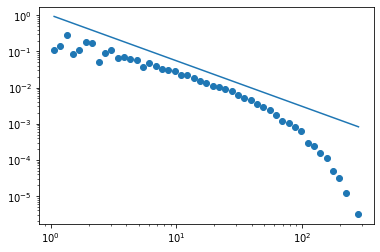

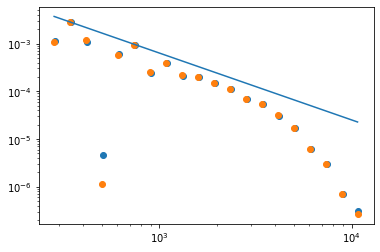

20


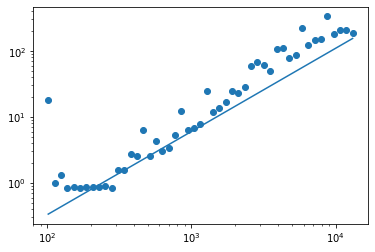

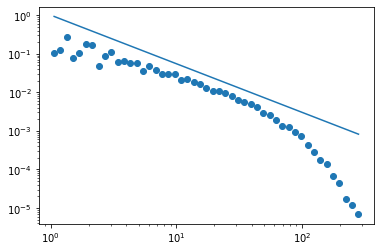

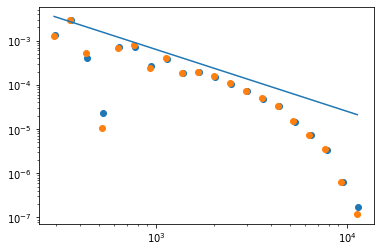

In [36]:
%matplotlib inline
for i in range(len(time_cuts)):
    for j in range(len(tols)):
        if(tols[j]==2):
            print(time_cuts[i])
            jumps,lat1,lat2, n_angles = summary_stat(interface_dict, x_dict,y_dict,cl_coll[i][j])
            mask = np.isfinite(lat1)
            x_group, y_group = mean_bin_group(lat1[mask],jumps[mask],np.logspace(np.log10(lat1[mask].min()),np.log10(lat1[mask].max())))
            plt.scatter(x_group,y_group)
            plt.plot(x_group, 0.001*x_group**1.26)
            plt.yscale('log')
            plt.xscale('log')
            plt.show()
            lat1 = lat1[np.isfinite(lat1)]
            lat2 = lat2[np.isfinite(lat2)]
            hist, edges, _ = bin_log(jumps[1000:])
            plt.scatter(edges,hist)
            plt.plot(edges,edges**(-1.26))
            plt.yscale('log')
            plt.xscale('log')
            plt.show()
            hist, edges, _ = bin_log(lat1[5000:])
            plt.scatter(edges,hist)
            hist, edges, _ = bin_log(lat2[5000:])
            plt.scatter(edges,hist)
            plt.plot(edges,10*edges**(-1.4))
            plt.yscale('log')
            plt.xscale('log')
            plt.show()
            

## Reconstruct interface

In [21]:
#polar coordinates
nrow=data.shape[0]
ncol=data.shape[1]
xcoord = np.arange(0,ncol).reshape(1,-1)
ycoord = np.arange(0,nrow).reshape(-1,1)
th=np.arctan2(ycoord-yc,xcoord-xc)
rr=np.sqrt(np.power((ycoord-yc),2) + np.power((xcoord-xc),2))
#pandas dataframe with triples (th,R,t)
table = pd.DataFrame(np.concatenate([th.reshape(-1,1),rr.reshape(-1,1),data.reshape(-1,1)],axis=1),columns=['th','R','t'])
table = table[table['t'] != -1]
table.sort_values('t', inplace=True)
table['t'] = table['t'].values.astype('int')
table.reset_index(inplace=True)
table.drop('index',axis=1, inplace=True)
max_t = int(table['t'].values.max())
t0 = 0
#discretize angles: th -> thi which is an index between 0 (-\pi) and discretization (\pi)
n_bins=700
bins = np.linspace(-np.pi, np.pi, n_bins)
digits = np.digitize(table['th'], bins)-1
table['thi'] = digits

min_idx = np.min(digits)
max_idx = np.max(digits)

hard_fix = max_idx == n_bins-2

if(hard_fix):
    print('Hard fix for boundary.')

x_dict = {}
y_dict = {}
t_dict = {}

for t in range(0,data.max()+1):
    if(t % 2000 == 0):
        print("Status: %2.1f%%" % (100*(t-t0)/(max_t+1-t0)))
    positions = np.argwhere(data==t)
    if(len(positions)>0):
        x_dict[t] = positions[:,0]
        y_dict[t] = positions[:,1]
        t_dict[t] = t
        
    


interface = {}  #np.zeros((max_t-t0+1,args.discretization))
for t in range(t0, max_t+1):
    if(t % 2000 == 0):
        print("Status: %2.1f%%" % (100*(t-t0)/(max_t+1-t0)))

    z = table[table['t'] <= t]
    rs = z.groupby('thi')['R'].max()
    interface[t] = np.zeros(n_bins)
    interface[t][rs.index] = rs.values
    if(hard_fix):
        interface[t][-1] = interface[t][0] #ensure pbc
with open("interface%1.2f.pkl" % field, 'wb') as f:
    pickle.dump([interface, x_dict, y_dict, t_dict],f)

Hard fix for boundary.
Status: 0.0%
Status: 2.8%
Status: 5.5%
Status: 8.3%
Status: 11.1%
Status: 13.8%
Status: 16.6%
Status: 19.4%
Status: 22.1%
Status: 24.9%
Status: 27.7%
Status: 30.5%
Status: 33.2%
Status: 36.0%
Status: 38.8%
Status: 41.5%
Status: 44.3%
Status: 47.1%
Status: 49.8%
Status: 52.6%
Status: 55.4%
Status: 58.1%
Status: 60.9%
Status: 63.7%
Status: 66.4%
Status: 69.2%
Status: 72.0%
Status: 74.8%
Status: 77.5%
Status: 80.3%
Status: 83.1%
Status: 85.8%
Status: 88.6%
Status: 91.4%
Status: 94.1%
Status: 96.9%
Status: 99.7%
Status: 0.0%
Status: 2.8%
Status: 5.5%
Status: 8.3%
Status: 11.1%
Status: 13.8%
Status: 16.6%
Status: 19.4%
Status: 22.1%
Status: 24.9%
Status: 27.7%
Status: 30.5%
Status: 33.2%
Status: 36.0%
Status: 38.8%
Status: 41.5%
Status: 44.3%
Status: 47.1%
Status: 49.8%
Status: 52.6%
Status: 55.4%
Status: 58.1%
Status: 60.9%
Status: 63.7%
Status: 66.4%
Status: 69.2%
Status: 72.0%
Status: 74.8%
Status: 77.5%
Status: 80.3%
Status: 83.1%
Status: 85.8%
Status: 88.6%
Statu

## Delta Area vs Time

We find all the increase in pixels ('amounts) at each time steps ('timesteps')

'T' is the last time step available

'topplings' contains the amount of "spins" flipped at each time step

Running a 'cumsum' over topplings gives an estimate of the growth of the domain area

In [70]:
timesteps, amounts = np.unique(data,return_counts=True)
timesteps = timesteps[1:]
amounts = amounts[1:]
T = timesteps.max() + 1

In [71]:
topplings = np.zeros(T)
topplings[timesteps] = amounts
delta_area = np.cumsum(topplings)

### Plot

We plot the radius obtained by the area difference

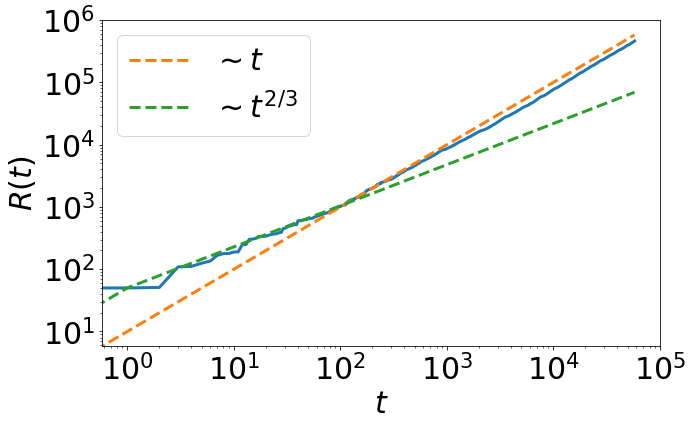

In [72]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(delta_area, lw=3)
plt.plot(np.arange(0,T), 10*np.arange(0,T), label='$\sim t$', ls='dashed', lw=3)
plt.plot(np.arange(0,T), 50*np.arange(0,T)**0.66, label='$\sim t^{2/3}$', ls='dashed', lw=3)
plt.ylabel("$R(t)$", fontsize=30)
plt.xlabel("$t$", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=30)
plt.show()

## Radius

## Topplings

We use the topplings above to obtain an avalanche size distribution

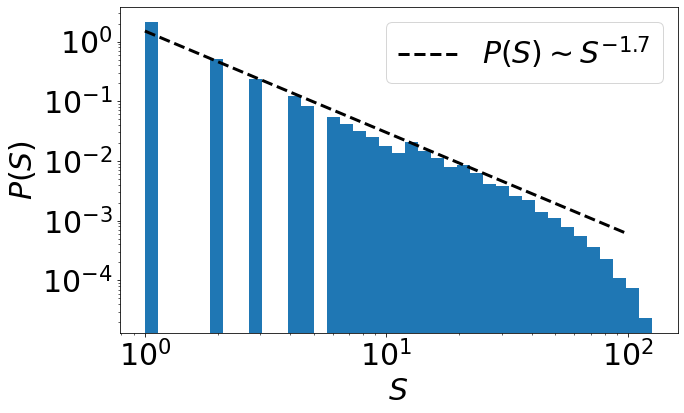

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
plt.hist(topplings, bins=np.logspace(0,2.1,40),density=True)
plt.plot(np.logspace(0,2),1.5*np.logspace(0,2)**(-1.7), label='$P(S) \sim S^{-1.7}$', ls='dashed', lw=3, color='black')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("$P(S)$", fontsize=30)
plt.xlabel("$S$", fontsize=30)
plt.legend(fontsize=30)
plt.show()

## Interface reconstruction (fix in progress)

In [ ]:
polar = {}
for t in timesteps:
  if(t % 5000 == 0):
    print(t)
  indices = np.argwhere(data==t)
  delta_r = indices[:, 0]-yc
  delta_c = indices[:, 1]-xc
  r_t =np.sqrt(delta_r**2+delta_c**2)
  theta_t = np.arctan2(delta_r, delta_c)
  polar[t] = (r_t, theta_t)

0
10000
15000
20000
25000
30000
40000
45000
55000


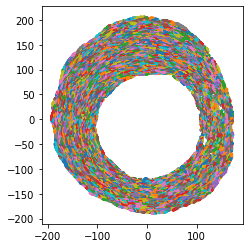

In [ ]:
for t in polar.keys():
  if(t > 10000):
    break
  plt.plot(polar[t][0]*np.cos(polar[t][1]),polar[t][0]*np.sin(polar[t][1]))
plt.gca().set_aspect('equal')

## Baiesi declustering approach

- We build a network like in the Baiesi declustering approach.

- First we have to make sure that all the sites activated at time $t$ belong or not to the same region

- We employ a Manhattan distance criterion: if all the sites at a given time are below a distance 'manhattan_tolerance' they are considered in the same region.

In [ ]:
events = {}
manhattan_tolerance = 2
for t in timesteps:
  if(t % 5000 == 0):
    print(t)
  t_events = []
  indices = np.argwhere(data==t)
  adj_matr = np.minimum(manhattan_distances(indices[:,0][:,None], indices[:,0][:,None]),manhattan_distances(indices[:,1][:,None], indices[:,1][:,None])) <= manhattan_tolerance
  g = nx.from_numpy_array(adj_matr)
  components = list(nx.connected_components(g))
  for comp in components:
    t_events.append(indices[list(comp),:])
  events[t] = t_events

0
10000
15000
20000
25000
30000
40000
45000
55000


- We build a 'seismic' catalog of (time, epi_row, epic_col, size) where epic_row and epic_col is the average position of the activated region

In [ ]:
catalog = []
for t, evs in events.items():
  for ev in evs:
    catalog.append((t, len(ev), ev[:,0].mean(), ev[:,1].mean()))
catalog = np.array(catalog)

- We run the Baiesi declustering method to obtain 'seismic' sequences
- Reciprocal correlation between two 'seismic' events $i$ and $j$ with $t_i > t_j$ is given by:
$$ n_{ij} =(t_i-t_j) dr_{ij}^{d_f} e^{-\tau \ln s_j } $$
with $s_j$ the size of event $j$ and $dr_{ij}$ the distance between epicenters. We use $d_f=2$ and $\tau=2$.

In [ ]:
b = 1.0
max_dt_backward = 5000
g_decl = nx.DiGraph()
for event_idx in range(catalog.shape[0]):
  if(event_idx % 1000 == 0):
    print("%.2f" % (100*event_idx/catalog.shape[0]))
  best_n_ij = np.infty
  best_i = -1
  for event_jdx in range(max(0,event_idx-max_dt_backward),event_idx):
    dt_ij = catalog[event_idx, 0] - catalog[event_jdx, 0]
    # can't connect equal-time events
    if(dt_ij == 0):
      continue
    dr_ij = np.sqrt((catalog[event_idx, 1] - catalog[event_jdx, 1])**2+(catalog[event_idx, 2] - catalog[event_jdx, 2])**2)
    size_effect_j = np.exp(-2*np.log(catalog[event_jdx,3]))
    n_ij = dt_ij*(dr_ij**2)*size_effect_j
    if(n_ij < best_n_ij):
      best_i = event_idx
      best_n_ij = n_ij
  g_decl.add_edge(event_idx,event_jdx, weight=best_n_ij)

0.00
1.87
3.74
5.61
7.48
9.35
11.22
13.09
14.96
16.83
18.71
20.58
22.45
24.32
26.19
28.06
29.93
31.80
33.67
35.54
37.41
39.28
41.15
43.02
44.89
46.76
48.63
50.50
52.37
54.25
56.12
57.99
59.86
61.73
63.60
65.47
67.34
69.21
71.08
72.95
74.82
76.69
78.56
80.43
82.30
84.17
86.04
87.91
89.79
91.66
93.53
95.40
97.27
99.14


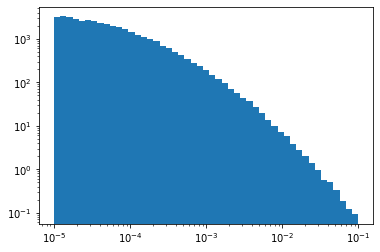

In [ ]:
weights = np.array([w for n1,n2, w in g_decl.edges(data='weight')])
weights[0] = 0
plt.hist(np.sort(weights[weights>0]), bins=np.logspace(-5,-1), density=True)
plt.xscale('log')
plt.yscale('log')


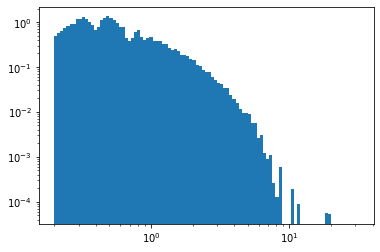

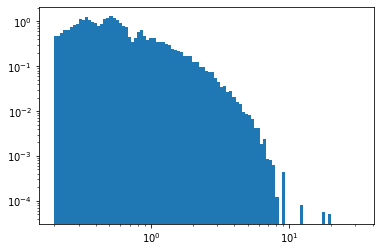

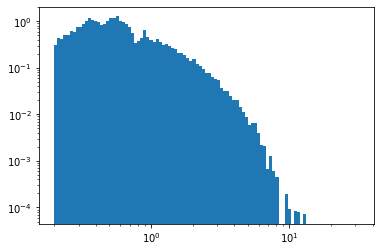

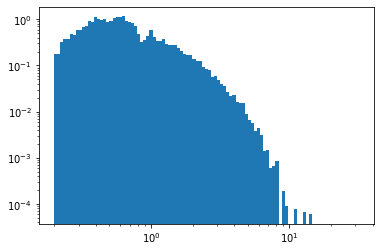

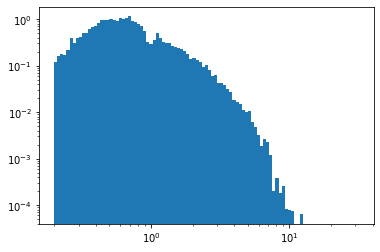

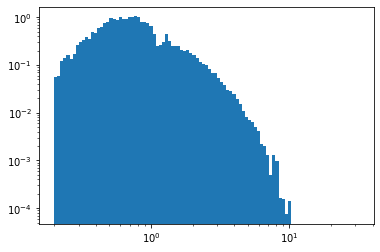

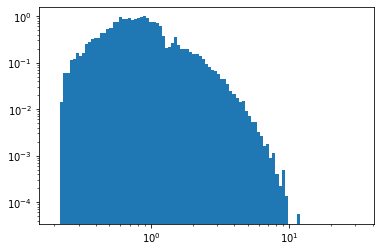

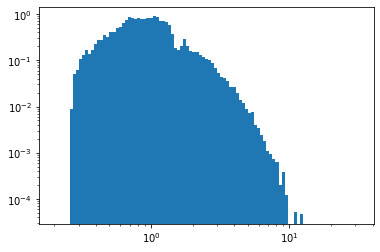

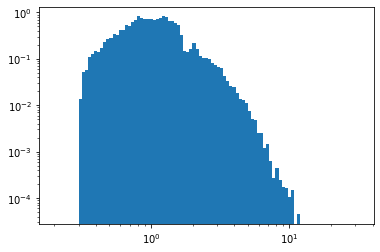

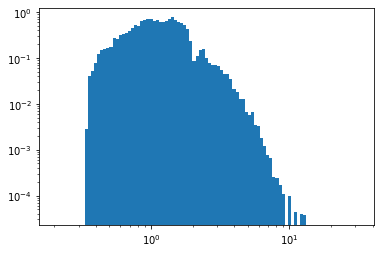

In [ ]:
for n_max in np.logspace(-5,-3,10):
  g_cut = g_decl.copy()
  g_cut.remove_edges_from([(n1, n2) for n1, n2, w in g_cut.edges(data="weight") if w <= n_max])
  n_c = np.array([len(c) for c in nx.weakly_connected_components(g_cut)])
  s_c = np.array([ catalog[list(c),3].sum()  for c in nx.weakly_connected_components(g_cut)])
  s_max = np.mean(s_c**2)/(2*np.mean(s_c))
  plt.hist(s_c/s_max, bins=np.logspace(-0.7,1.5,100), density=True)
  plt.yscale('log')
  plt.xscale('log')
  plt.show()